In [1]:
import mysql.connector as mysql
import pandas as pd
import folium
import requests
import googlemaps
from geopy.distance import geodesic
import numpy as np
from tqdm import tqdm
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from matplotlib import font_manager
from matplotlib import rc

#database-1.c9ks828mszs7.ap-northeast-2.rds.amazonaws.com


In [2]:
remote = mysql.connect (
    host = "database-1.c9ks828mszs7.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "roschool",
    password = "1234",
    database = "roschool"
)

# 규모별 경력 선호도

In [3]:
cursor = remote.cursor(buffered=True)

#규모별 경력 학력
sql_1 = """
               SELECT 
    ct.type AS 기업규모,
    CASE 
        WHEN ca.career IN ('경력무관', '초대졸이상') THEN '경력무관'
        WHEN ca.career = '신입' THEN '신입'
        WHEN ca.career IN ('경력1년이상', '경력2년이상', '경력3년이상') THEN '1-3년'
        WHEN ca.career IN ('경력4년이상', '경력5년이상', '경력6년이상') THEN '4-6년'
        WHEN ca.career IN ('경력7년이상', '경력10년이상', '경력8년이상', '경력16년이상') THEN '7년이상'
        ELSE '기타'
    END AS 경력,
    COUNT(*) AS 선호도
FROM 
    recruit_info re
JOIN 
    company_info co ON re.comp_name_id = co.comp_id
JOIN 
    comp_type ct ON co.comp_type_id = ct.comp_type_id
JOIN 
    career_info ca ON re.career_id = ca.career_id
WHERE 
    ct.type != "정보없음" 
    AND ct.type != "기타" 
    AND ct.type NOT LIKE "%코스%"
    AND ca.career != "정보없음"
GROUP BY 
    ct.type, 경력
ORDER BY 
    ct.type, 선호도 DESC;

"""

cursor.execute(sql_1)

result = cursor.fetchall()

df = pd.DataFrame(result)

df

,0,1,2
0,강소기업,1-3년,6
1,강소기업,4-6년,4
2,강소기업,신입,4
3,강소기업,경력무관,2
4,대기업,신입,2
5,대기업,경력무관,1
6,벤처기업,1-3년,24
7,벤처기업,경력무관,8
8,벤처기업,4-6년,5
9,벤처기업,신입,2


In [5]:
df.columns = ["기업규모", "경력", "수"]

In [7]:
# 기업규모 정렬 순서 설정
order = ["스타트업", "벤처기업", "강소기업", "중소기업", "중견기업", "대기업"]
df["기업규모"] = pd.Categorical(df["기업규모"], categories=order, ordered=True)

# DataFrame 
df = df.sort_values(by=["기업규모", "경력"]).reset_index(drop=True)

df

,기업규모,경력,수
0,스타트업,1-3년,4
1,스타트업,4-6년,4
2,스타트업,경력무관,4
3,스타트업,신입,1
4,벤처기업,1-3년,24
5,벤처기업,4-6년,5
6,벤처기업,7년이상,1
7,벤처기업,경력무관,8
8,벤처기업,신입,2
9,강소기업,1-3년,6


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기업규모    24 non-null     object
 1   경력      24 non-null     object
 2   수       24 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 704.0+ bytes


# 막대 그래프

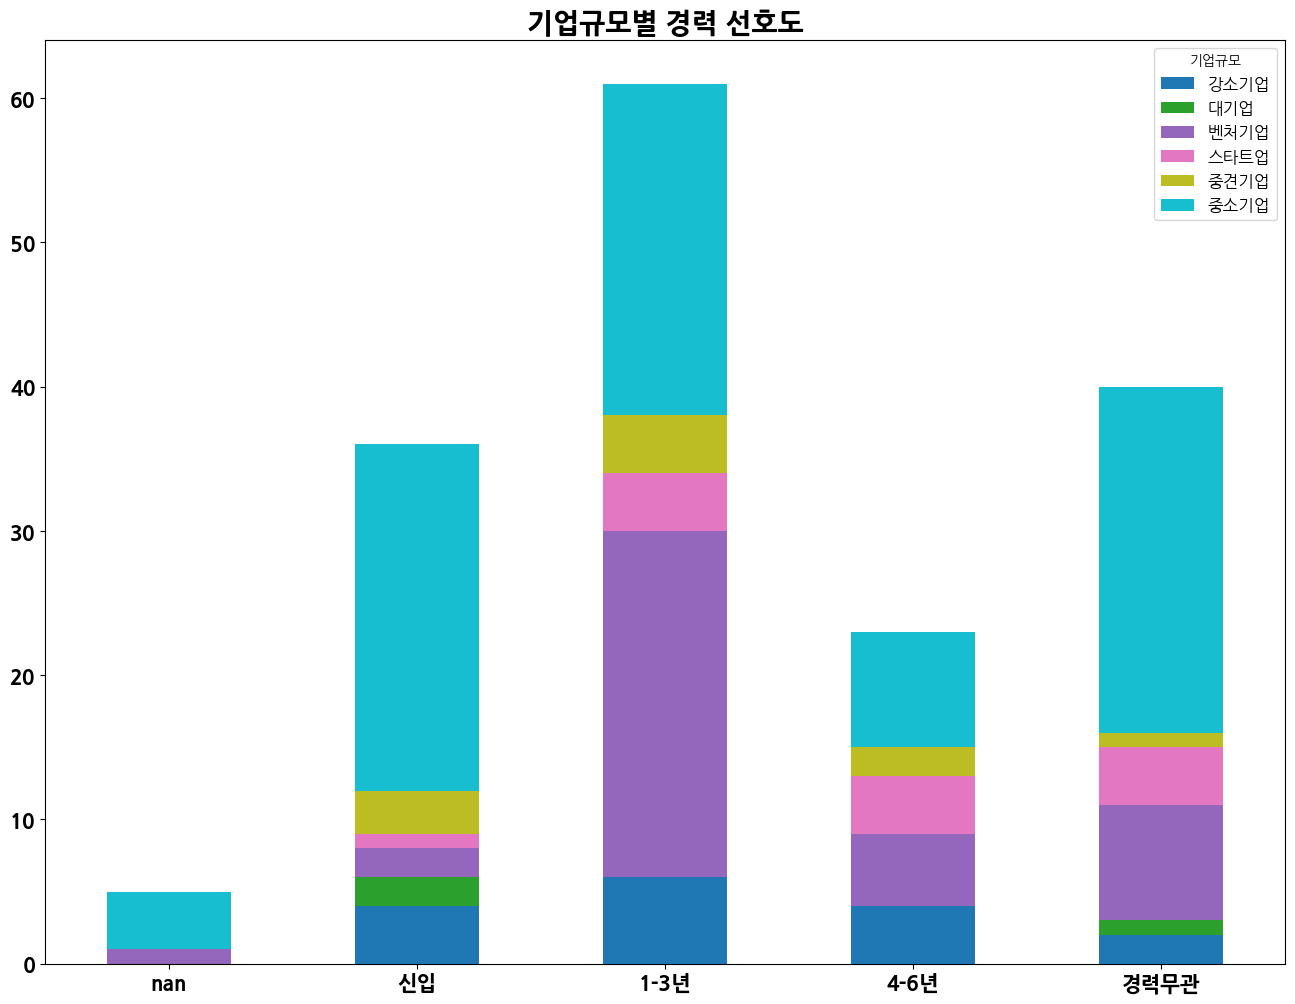

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager

# 한글 폰트 설정 (Linux: NanumGothic)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path)
rc('font', family=font.get_name())

colors = ["#4D8DFF", "#FC5E1A", "#343FB5", "#FAC7FF", "#43D675"]

# 데이터 Pivot (기업규모별로 그룹화)
pivot_df = df.pivot(index="경력", columns="기업규모", values="수").fillna(0)

# 막대 그래프 그리기 (Stacked)
pivot_df.plot(kind="bar", stacked=True, figsize=(16, 12), colormap="tab10")



# 그래프 설정
plt.xticks(fontsize=15, fontweight="bold", rotation=0)
plt.yticks(fontsize=15, fontweight="bold")
plt.title("기업규모별 경력 선호도", fontsize=20, fontweight="bold")
plt.xlabel("")  # x축 라벨 제거
plt.legend(title="기업규모", fontsize=12)

# 그래프 표시
plt.show()



/tmp/ipykernel_10611/1702481980.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(["기업규모", "경력"])["수"].sum().unstack().fillna(0)


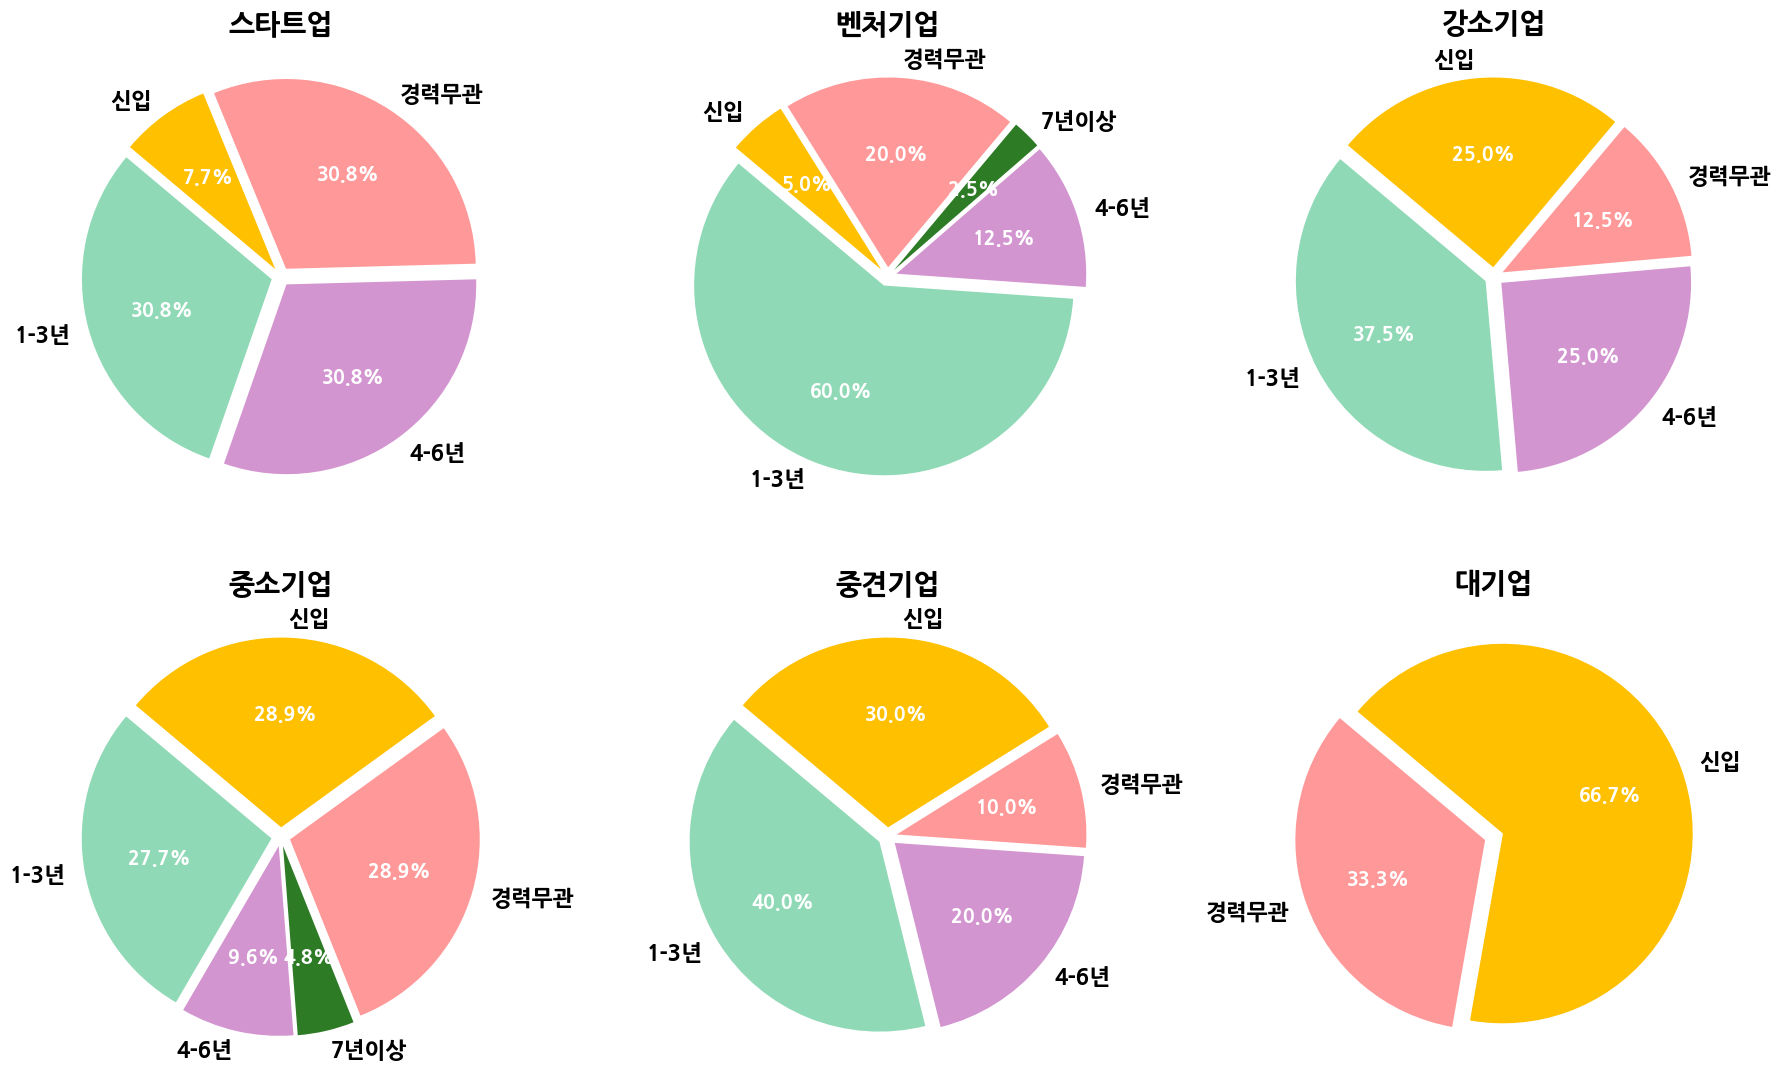

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager

# 한글 폰트 설정 (Linux: NanumGothic)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path)
rc('font', family=font.get_name())

## 기업규모별 데이터 준비
grouped_data = df.groupby(["기업규모", "경력"])["수"].sum().unstack().fillna(0)

# 색상 매핑 딕셔너리
colors_dict = {
    "경력무관": "#ff9999",  # 빨간색
    "신입": "#ffc000",  # 노란색
    "1-3년": "#8fd9b6",  # 초록색
    "4-6년": "#d395d0",  # 보라색
    "7년이상": "#2E7B26"  # 진한 초록색
}

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2행 3열 서브플롯
axes = axes.flatten()  # 축 배열을 1차원으로 변환

# 각 기업규모별 파이 차트 생성
for i, (company, data) in enumerate(grouped_data.iterrows()):
    # 0% 항목 제거
    data = data[data > 0]

    # 데이터에 맞는 색상 리스트 생성
    data_colors = [colors_dict[label] for label in data.index]

    # explode 설정 (항목별로 분리)
    explode = [0.05] * len(data)

    # 파이 차트 생성
    wedges, texts, autotexts = axes[i].pie(
        data,
        labels=data.index,
        autopct=lambda p: f"{p:.1f}%" if p > 0 else "",  # 0% 숨김
        startangle=140,
        colors=data_colors,  # 색상 매핑
        explode=explode,
        textprops={"fontsize": 16, "color": "black", "fontweight": "bold"}  # 항목 텍스트: 검은색, 굵게
    )

    # 퍼센트 텍스트 색상 변경 (autotexts 설정)
    for autotext in autotexts:
        autotext.set_color("white")  # 퍼센트 텍스트: 흰색
        autotext.set_fontsize(14)
        autotext.set_fontweight("bold")

    # 차트 제목 설정
    axes[i].set_title(f"{company}", fontsize=20, fontweight="bold")

# 전체 제목 설정
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보
plt.show()


# 경력 무관, 신입

In [9]:
cursor = remote.cursor(buffered=True)

#규모별 경력 학력
sql_1 = """
               SELECT 
    ct.type AS 기업규모,
    CASE 
        WHEN ca.career IN ('경력무관', '초대졸이상') THEN '경력무관'
        WHEN ca.career = '신입' THEN '신입'
        ELSE '기타'
    END AS 경력,
    COUNT(*) AS 선호도
FROM 
    recruit_info re
JOIN 
    company_info co ON re.comp_name_id = co.comp_id
JOIN 
    comp_type ct ON co.comp_type_id = ct.comp_type_id
JOIN 
    career_info ca ON re.career_id = ca.career_id
WHERE 
    ct.type != "정보없음" 
    AND ct.type != "기타" 
    AND ct.type NOT LIKE "%코스%"
    AND ca.career != "정보없음"
GROUP BY 
    ct.type, 경력
ORDER BY 
    ct.type, 선호도 DESC;

"""

cursor.execute(sql_1)

result = cursor.fetchall()

df = pd.DataFrame(result)

df

,0,1,2
0,강소기업,기타,10
1,강소기업,신입,4
2,강소기업,경력무관,2
3,대기업,신입,2
4,대기업,경력무관,1
5,벤처기업,기타,30
6,벤처기업,경력무관,8
7,벤처기업,신입,2
8,스타트업,기타,8
9,스타트업,경력무관,4


In [12]:
df.columns = ["기업규모", "경력", "수"]

In [13]:
# 기업규모 정렬 순서 설정
order = ["스타트업", "벤처기업", "강소기업", "중소기업", "중견기업", "대기업"]
df["기업규모"] = pd.Categorical(df["기업규모"], categories=order, ordered=True)

# DataFrame 
df = df.sort_values(by=["기업규모", "경력"]).reset_index(drop=True)

df

,기업규모,경력,수
0,스타트업,경력무관,4
1,스타트업,기타,8
2,스타트업,신입,1
3,벤처기업,경력무관,8
4,벤처기업,기타,30
5,벤처기업,신입,2
6,강소기업,경력무관,2
7,강소기업,기타,10
8,강소기업,신입,4
9,중소기업,경력무관,24


In [ ]:
new_df = df[df["경력"] != "기타"]


In [24]:
new_df

,기업규모,경력,수
0,스타트업,경력무관,4
2,스타트업,신입,1
3,벤처기업,경력무관,8
5,벤처기업,신입,2
6,강소기업,경력무관,2
8,강소기업,신입,4
9,중소기업,경력무관,24
11,중소기업,신입,24
12,중견기업,경력무관,1
14,중견기업,신입,3


/tmp/ipykernel_10611/3831672051.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = new_df.groupby(["기업규모", "경력"])["수"].sum().unstack().fillna(0)


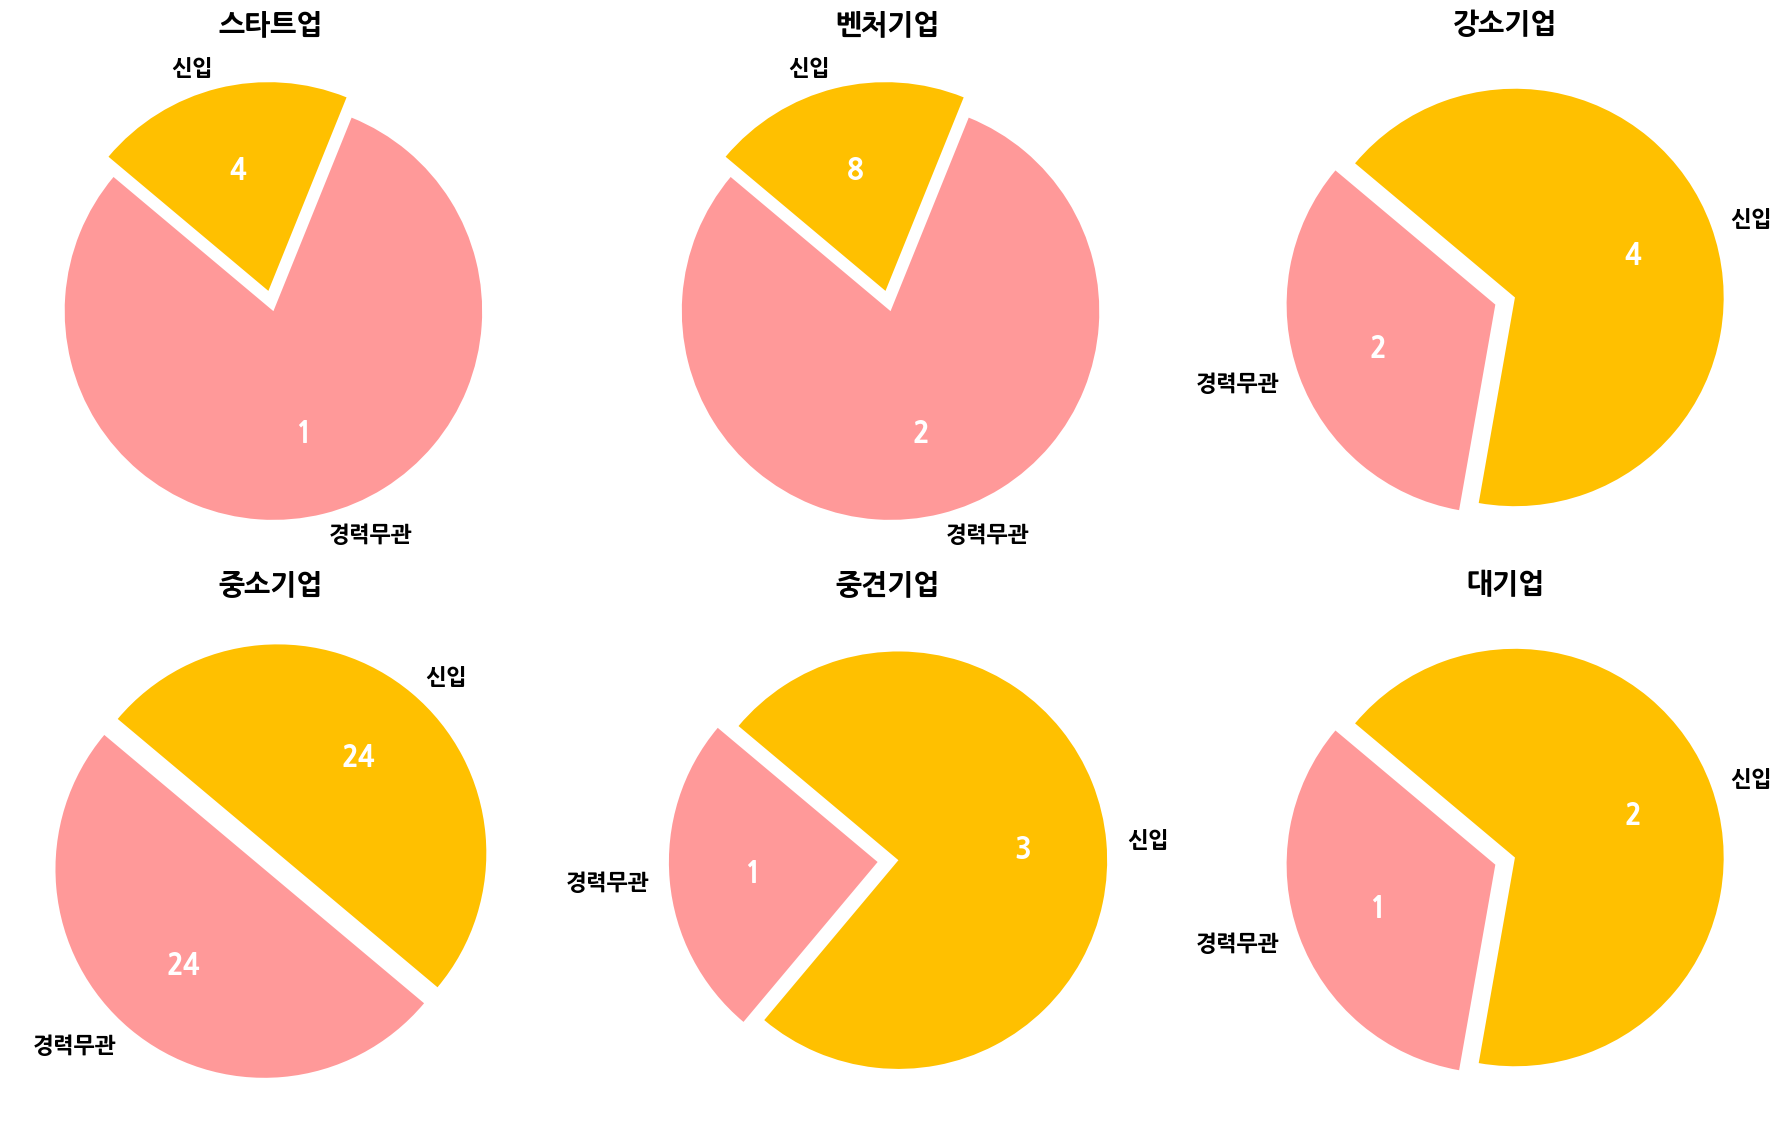

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import font_manager

# 한글 폰트 설정 (Linux: NanumGothic)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path)
rc('font', family=font.get_name())

## 기업규모별 데이터 준비
grouped_data = new_df.groupby(["기업규모", "경력"])["수"].sum().unstack().fillna(0)

# 색상 매핑 딕셔너리
colors_dict = {
    "경력무관": "#ff9999",  # 빨간색
    "신입": "#ffc000",  # 노란색
    "1-3년": "#8fd9b6",  # 초록색
    "4-6년": "#d395d0",  # 보라색
    "7년이상": "#2E7B26"  # 진한 초록색
}

# 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2행 3열 서브플롯
axes = axes.flatten()  # 축 배열을 1차원으로 변환

# 각 기업규모별 파이 차트 생성
for i, (company, data) in enumerate(grouped_data.iterrows()):
    # 0% 항목 제거
    data = data[data > 0]

    # 데이터에 맞는 색상 리스트 생성
    data_colors = [colors_dict[label] for label in data.index]

    # explode 설정 (항목별로 분리)
    explode = [0.05] * len(data)

    # 파이 차트 생성
    wedges, texts, autotexts = axes[i].pie(
        data,
        labels=data.index,
        autopct=lambda p: f"{int(data.loc[data.index[int(p/100*len(data))]])}" if p > 0 else "",  # 0% 숨김
        startangle=140,
        colors=data_colors,  # 색상 매핑
        explode=explode,
        textprops={"fontsize": 16, "color": "black", "fontweight": "bold"}  # 항목 텍스트: 검은색, 굵게
    )

    # 퍼센트 텍스트 색상 변경 (autotexts 설정)
    for autotext in autotexts:
        autotext.set_color("white")  # 퍼센트 텍스트: 흰색
        autotext.set_fontsize(20)
        autotext.set_fontweight("bold")

    # 차트 제목 설정
    axes[i].set_title(f"{company}", fontsize=20, fontweight="bold")

# 전체 제목 설정
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보
plt.show()


<Axes: xlabel='기업규모', ylabel='수'>

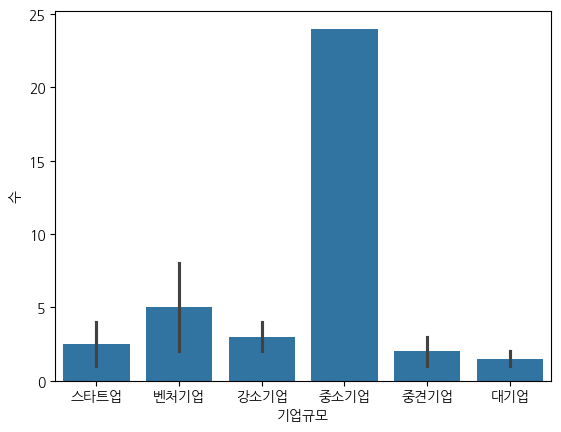

In [30]:
sns.barplot(x="기업규모", y="수", data=new_df)

/tmp/ipykernel_10611/2791621443.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = new_df.pivot_table(index="기업규모", columns="경력", values="수", aggfunc="sum", fill_value=0)


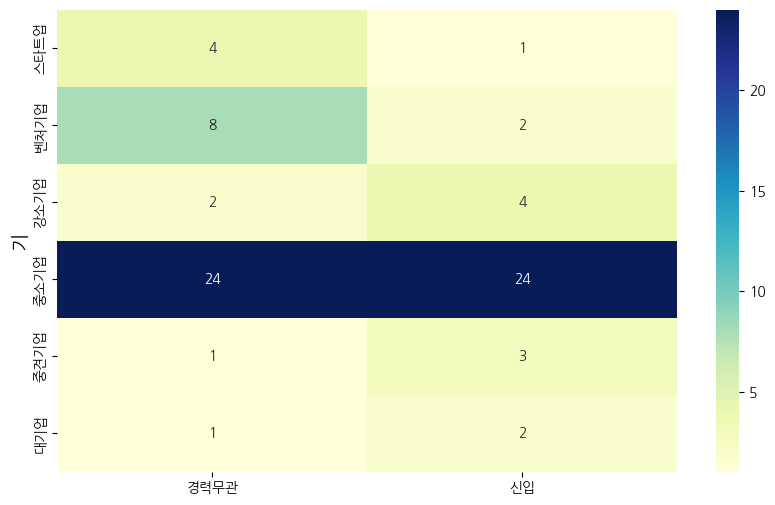

In [32]:
heatmap_data = new_df.pivot_table(index="기업규모", columns="경력", values="수", aggfunc="sum", fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
# plt.title("기업규모와 경력 간 관계 (히트맵)", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("기", fontsize=14)
plt.show()


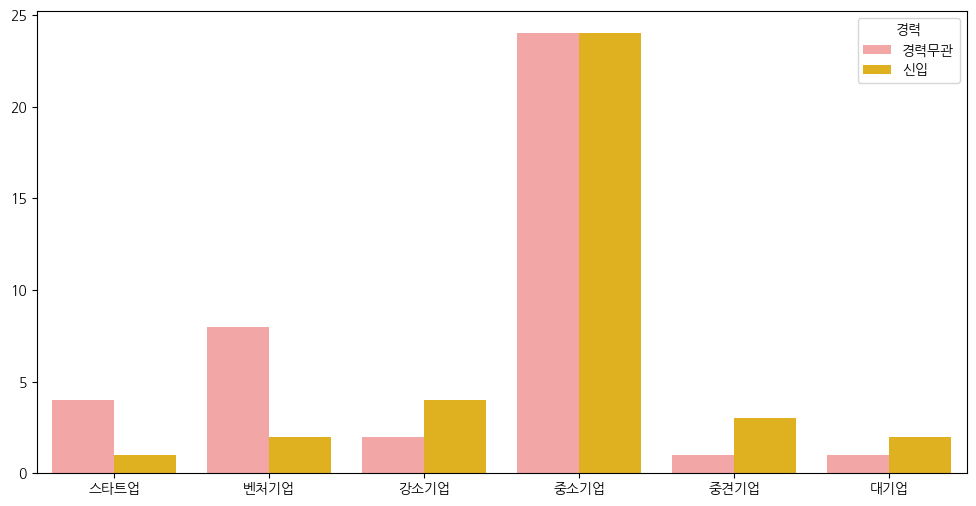

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 색상 지정
custom_palette = {
    "경력무관": "#ff9999",  # 빨간색
    "신입": "#ffc000",      # 노란색
    "1-3년": "#8fd9b6",    # 초록색
    "4-6년": "#d395d0",    # 보라색
    "7년이상": "#2E7B26"   # 진한 초록색
}

# 막대 그래프
plt.figure(figsize=(12, 6))
sns.barplot(data=new_df, x="기업규모", y="수", hue="경력", palette=custom_palette)
# plt.title("기업규모별 경력 수", fontsize=16)
plt.xlabel("", fontsize=16, fontweight = "bold")
plt.ylabel("", fontsize=16, fontweight = "bold")
plt.legend(title="경력")
plt.show()


In [50]:
remote.close()